In [1]:
import eds 
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import show as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [2]:
CONFIG = {}

CONFIG['LAT'] = 51.34083598409240
CONFIG['LON'] = 12.381819774766130
CONFIG['RADIUS'] = 300
CONFIG['NUM_UES'] = 400
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [3]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.05, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

In [4]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']
        
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#ea0a8e'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)


display(ul_scenario_map)

In [5]:
df_ue=pd.DataFrame(ue_data)

In [6]:
df_cell = pd.DataFrame(cell_data)

In [7]:
sectors=df_cell['pci'].unique()

In [8]:
d={}
for i in df_cell.index:
    #c=df_cell.loc[i]['cell']
    d.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [9]:
data=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
data = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [10]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [11]:
df=data.copy()
N=len(sectors)
SINR_list=np.array([])
SINR_CoMP_list=np.array([])
c_cell=np.array([])
s_cell=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:]
    P=P[2:2+N] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    pci_coord= index[1]
    SINR= P[0]/(np.sum(P[1:N])+noise)
    SINR_CoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:N])+noise)
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINR_CoMP_list=np.append(SINR_CoMP_list,10*np.log10(SINR_CoMP))
    s_cell=np.append(s_cell,index[0])
    c_cell=np.append(c_cell,index[1])

##### Building the dataframe

In [12]:
s_cell=s_cell.astype(int)
c_cell=c_cell.astype(int)
df['lat']=data['lat']
df['lon']=data['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINR_CoMP_list
df['PCI Serving']=s_cell
df['PCI Coord']=c_cell
df['qos']=np.zeros(len(data)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(data))

#### Sort out PCIs that have less than 10 users -> edge of the Scenario

In [13]:
#check if the number of users (positions) for the serving pci is >10
df_f=df.groupby('PCI Serving')
count=0
for i in df['PCI Serving'].unique():
    k=df_f.get_group(i)
    if(len(k)<10):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['PCI Serving']!=i]
    count+=1

#### Have a look for how many users comp is benefitial

In [14]:
Thr=6
df[df['SINR-CoMP [dB]']-df['SINR [dB]']>Thr]

,lat,lon,168,169,170,757,758,756,105,107,...,630,531,533,532,SINR [dB],SINR-CoMP [dB],PCI Serving,PCI Coord,qos,id
1,51.339779,12.378754,-130,-137,-110,-132,-148,-124,-125,-122,...,-143,-142,-151,-124,4.036461,10.301501,319,133,0.0,1
3,51.341593,12.383395,-144,-144,-114,-141,-151,-125,-117,-115,...,-138,-143,-147,-119,-5.197560,2.385511,775,774,0.0,3
5,51.342499,12.381381,-142,-142,-112,-141,-149,-122,-115,-122,...,-142,-148,-149,-120,9.917905,16.056734,134,320,0.0,5
7,51.340258,12.380576,-135,-140,-112,-135,-149,-125,-123,-119,...,-141,-142,-149,-122,2.644856,12.611665,775,133,0.0,7
8,51.340966,12.383586,-141,-144,-115,-139,-151,-125,-120,-114,...,-137,-141,-147,-119,0.247141,10.112545,774,775,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,51.340545,12.380954,-137,-141,-112,-136,-149,-124,-122,-119,...,-141,-142,-149,-121,2.002343,13.529137,775,133,0.0,389
392,51.341771,12.381681,-142,-142,-112,-139,-149,-123,-118,-120,...,-141,-145,-148,-120,-0.933446,5.965431,133,320,0.0,392
394,51.339089,12.382536,-133,-142,-116,-135,-151,-127,-128,-116,...,-137,-137,-148,-122,5.770625,22.185894,776,775,0.0,394
395,51.340019,12.382938,-137,-143,-115,-137,-151,-126,-124,-115,...,-138,-139,-147,-120,14.241149,23.612965,775,774,0.0,395


#### Define general parameters for the simulation
if it says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [15]:
cluster=[775,133]

In [16]:
cluster=[775,133]
max_prb=50
ue_nr=15

size=4000
env=simpy.Environment()
ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
index=np.array([np.arange(0,15),np.arange(0,15)])
ue_dict_red=eds.restrict_users_to_cluster(ue_dict,cluster)
ue_dict_red2,ue_all=eds.get_user_from_cluster(ue_dict_red,cluster,ue_nr,index)

## Analysis for k=arrival 4ms

In [100]:
r='random'
#r='deterministic'
k=4
metric=[1,1]
env=simpy.Environment()
sched1=eds.sched_inst(env)
sched2=eds.sched_inst(env)
sched3=eds.sched_inst(env)
sched_l=[sched1,sched2]

index=np.array([np.arange(0,ue_nr),np.arange(0,ue_nr)])
ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
ue_dict_red=eds.restrict_users_to_cluster(ue_dict,cluster)

if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict_red[i]))),ue_nr)
        counter+=1
        
ue_dict_red2,ue_all=eds.get_user_from_cluster(ue_dict_red,cluster,ue_nr,index)
    
env=simpy.Environment()
    #Start processes
prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_dict_red2[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,k))

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_dict_red2[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    sched=sched_l[counter]
    env.process(sched.scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=100
env.run(until=timer)

sinr out of range


In [101]:
for i in ue_comp:
    print(i.cell1)

775.0
775.0
775.0
775.0
775.0
775.0
775.0
133.0
133.0
133.0
133.0
133.0


In [103]:
np.save('index',index)

### Graph Visualization

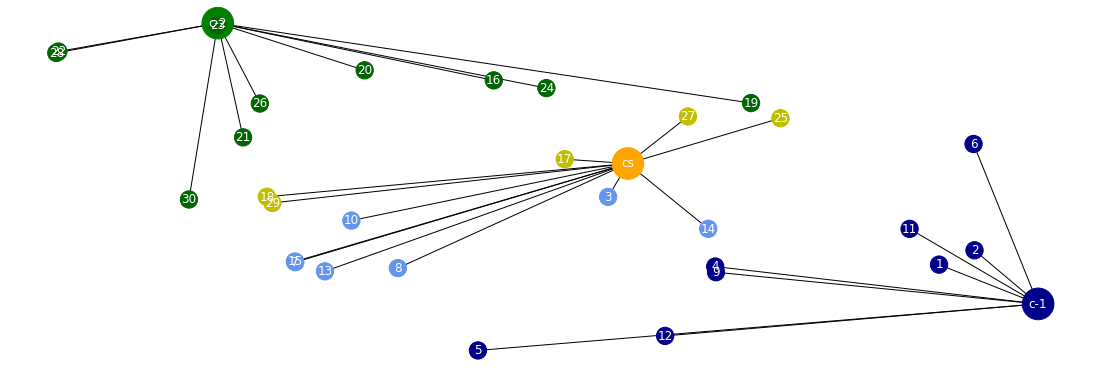

In [109]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
d={}
for i in df_cell.index:
    d.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lat'],df_cell.loc[i]['lon']]})
    
BS_pos=np.array([])
for i in cluster:
    BS_pos=np.append(BS_pos,d[i])

G=nx.Graph()

x=np.arange(1,ue_nr*2)
G.add_node('cs')
G.add_node('c-1')
G.add_node('c-2')

loc_dic={}
loc_dic.update({'cs':[(BS_pos[1]+BS_pos[3])/2,(BS_pos[0]+BS_pos[2])/2]})
loc_dic.update({'c-1':[BS_pos[1],BS_pos[0]]}) 
loc_dic.update({'c-2':[BS_pos[3],BS_pos[2]]})     
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    counter+=1

G.add_nodes_from(x)

n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    #loc_dic.update({counter:[i.x,i.y]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        if(i.cell1==cluster[0]):
            n_c=np.append(n_c,'cornflowerblue')
        elif(i.cell1==cluster[1]):
            n_c=np.append(n_c,'y')
    else:
        if(i.cell1==cluster[0]):
            G.add_edge(counter,'c-1')
            n_c=np.append(n_c,'darkblue')
        elif(i.cell1==cluster[1]):
            G.add_edge(counter,'c-2')
            n_c=np.append(n_c,'darkgreen')
    counter+=1
            
n_s=np.ones(ue_nr*2+3)*300
n_s[0:3]=1000

m=np.array([])
m=np.append(m,[1,1,1])
t=np.array([])
t=np.append(t,[1,1,1])
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs2)
    else:
        t=np.append(t,i.tbs)
vmin = np.min(m)
vmax = np.max(m)
m=10*np.log10(m)

plt.figure(3,figsize=(15,5)) 
#cmap='RdBu'
cmap='RdYlGn'
if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)
plt.draw()
plt.show()

## Results

In [75]:
m=0
for i in ue_all[0:ue_nr]:
    m+=i.mR2/i.mR
m=((m/ue_nr)-1)*100

m2=0
for i in ue_all[ue_nr:ue_nr*2]:
    m2+=i.mR2/i.mR
m2=((m2/ue_nr)-1)*100


print('average comp gain cell 1 : '+str(round(m,2))+'%')
print('average comp gain cell 2 : '+str(round(m2,2))+'%')
print('average comp gain: '+str(round((m+m2)/2,2))+'%')

average comp gain cell 1 : 37.21%
average comp gain cell 2 : -3.51%
average comp gain: 16.85%


all ues
10% Quantil: -37.69466430311418
90% Quantil: 99.73483459425557
50% Quantil (Median): -10.264486920124828
comp ues
10% Quantil: 35.8588113060498
90% Quantil: 124.50082548223232
50% Quantil (Median): 76.92632314393447
no_comp ues
10% Quantil: -37.75019267943026
90% Quantil: -10.122619157620534
50% Quantil (Median): -37.44427761802862


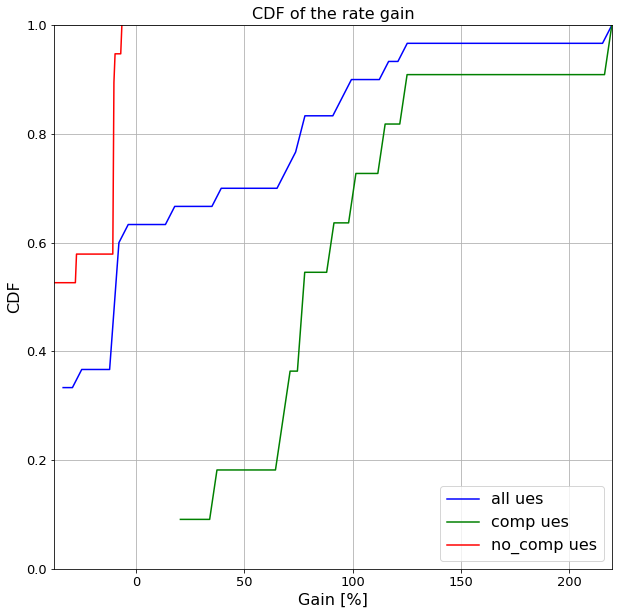

In [59]:
x=np.array([])
y=np.array([])
z=np.array([])
for i in ue_all:
    if(i.comp==0):
        z=np.append(z,i.mR2/i.mR)
    if(i.comp==1):
        y=np.append(y,i.mR2/i.mR)
    x=np.append(x,i.mR2/i.mR)
x=(x-1)*100
y=(y-1)*100    
z=(z-1)*100

sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [%]',60)

In [43]:
print('average comp gain: '+str(round(x.mean(),2))+'%')

average comp gain: 16.85%


all ues
10% Quantil: -2.0547477449624534
90% Quantil: 3.0035417898580072
50% Quantil (Median): -0.47035740586151525
comp ues
10% Quantil: 1.3308781042045474
90% Quantil: 3.5121794222896026
50% Quantil (Median): 2.477924521617708
no_comp ues
10% Quantil: -2.058619986412146
90% Quantil: -0.4634974400584728
50% Quantil (Median): -2.0373295639036413


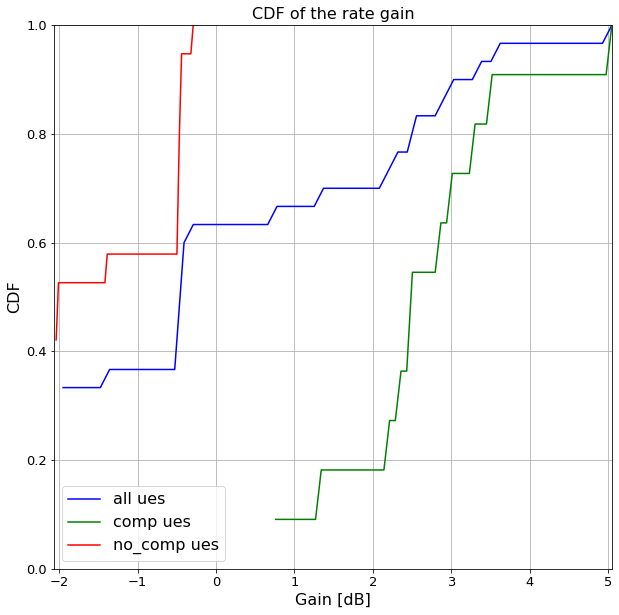

In [56]:
x=np.array([])
y=np.array([])
z=np.array([])
for i in ue_all:
    if(i.comp==0):
        z=np.append(z,i.mR2/i.mR)
    if(i.comp==1):
        y=np.append(y,i.mR2/i.mR)
    x=np.append(x,i.mR2/i.mR)
x=10*np.log10(x)
y=10*np.log10(y)
z=10*np.log10(z)

sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [dB]',60)

## Analyisis for PRBs

In [105]:
 np.arange(10,40,10)

array([10, 20, 30])

In [ ]:
liste1=random.sample(range(1, len(ue_dict_red[i])), ue_nr)

In [105]:
load1_l=np.array([])
load2_l=np.array([])
s_l={}
s_l2={}
ran=np.arange(1,40,1)
prb_dict={}
metric=[1,1]
speicher={}
r='random'
r='deterministic'

index=np.load('index.npy')
#index=np.array([np.arange(0,ue_nr),np.arange(0,ue_nr)])
ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
ue_dict_red=eds.restrict_users_to_cluster(ue_dict,cluster)
if(r=='random'):
    counter=0
    for i in cluster:
        #index[counter]=random.sample(list(np.arange(1,len(ue_dict_red[i]))),ue_nr)
        counter+=1
   
for prb_number_comp in np.arange(10,40,2):
    #prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
    prb_number_normal=max_prb-prb_number_comp
    for k in ran:
        env=simpy.Environment()
        sched1=eds.sched_inst(env)
        sched2=eds.sched_inst(env)
        sched3=eds.sched_inst(env)
        sched_l=[sched1,sched2]


        ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
        ue_dict_red2,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

        env=simpy.Environment()
        #Start processes

        SCHEDULE_T=2 #Clock des Schedulers 
        for i in cluster:
            ue_list=ue_dict_red2[i]
            for j in ue_list:
                env.process(j.best_effort_stat(env,k))

        ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
        for i in cluster:
            ue_list=ue_dict_red2[i]
            new_ue_list=np.array([])
            for j in ue_list:
                if(j.comp == 0):
                    new_ue_list=np.append(new_ue_list,j)
                else:
                    ue_comp=np.append(ue_comp,j)
            ue_dict[i]=new_ue_list #user without comp

        env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

        counter=0
        for i in cluster:
            ue_list=ue_dict[i]
            ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
            sched=sched_l[counter]
            env.process(sched.scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
            counter=counter+1
        timer=2000
        env.run(until=timer)
        liste=np.array([])

        av=0
        for i in ue_all:
            liste=np.append(liste,((i.mR2/i.mR)-1)*100)
            av+=i.mR2/i.mR
        av=av/(ue_nr*2)
        speicher.update({k:liste})

        rem1=0
        req1=0
        load1=0
        rem2=0
        req2=0
        load2=0
        ind=int(timer/2-2)
        for i in np.arange(100,ind):
            rem1+=sched1.rem_prb[ind]
            req1+=sched1.rem_req[ind]
            load1+=(sched1.rem_req[ind]+(max_prb-sched1.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)

            rem2+=sched2.rem_prb[ind]
            req2+=sched2.rem_req[ind]
            load2+=(sched2.rem_req[ind]+(max_prb-sched2.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)

        load1_l=np.append(load1_l,load1/len(np.arange(100,ind)))
        load2_l=np.append(load2_l,load2/len(np.arange(100,ind)))
        
    l=np.array([])
    l2=np.array([])
    for i in ran:
        x=speicher.get(i)
        l=np.append(l,x.mean())
    s_l.update({prb_number_comp:l})


sinr out of range
sinr out of range


C:\Users\Caroline Zoll\EDS\eds.py:215: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds.py:245: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out o

sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out of range
sinr out o

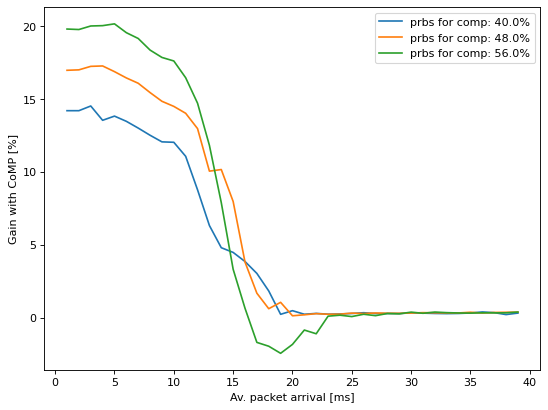

In [117]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
for i in np.arange(20,30,4):
    plt.plot(ran,s_l[i],label='prbs for comp: '+str(i*100/max_prb)+'%')
#plt.plot(ran,l,label='cell1',color='red')
#plt.plot(ran,l2,label='cell2',color='blue')
plt.xlabel('Av. packet arrival [ms]')
#plt.title('Comparison of both cells in the cluster with '+ str(prb_number_comp*100/max_prb)+'% of the prbs for comp')
plt.ylabel('Gain with CoMP [%]')
plt.legend(loc='upper right')


In [56]:
load1_l=np.array([])
load2_l=np.array([])
speicher={}
ran=np.arange(1,4,2)
metric=[1,1]
prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp

#r='random'
r='deterministic'

index=np.array([np.arange(0,ue_nr),np.arange(0,ue_nr)])
ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
ue_dict_red=eds.restrict_users_to_cluster(ue_dict,cluster)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict_red[i]))),ue_nr)
        counter+=1
   

for k in ran:
    env=simpy.Environment()
    sched1=eds.sched_inst(env)
    sched2=eds.sched_inst(env)
    sched3=eds.sched_inst(env)
    sched_l=[sched1,sched2]

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    ue_dict_red2,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)
    
    env=simpy.Environment()
    #Start processes

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_dict_red2[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,k))

    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_dict_red2[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        sched=sched_l[counter]
        env.process(sched.scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=5000
    env.run(until=timer)
    liste=np.array([])
    
    av=0
    for i in ue_all:
        liste=np.append(liste,((i.mR2/i.mR)-1)*100)
        av+=i.mR2/i.mR
    av=av/(ue_nr*2)
    speicher.update({k:liste})
    
    rem1=0
    req1=0
    load1=0
    rem2=0
    req2=0
    load2=0
    ind=int(timer/2-2)
    for i in np.arange(100,ind):
        rem1+=sched1.rem_prb[ind]
        req1+=sched1.rem_req[ind]
        load1+=(sched1.rem_req[ind]+(max_prb-sched1.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)
        
        rem2+=sched2.rem_prb[ind]
        req2+=sched2.rem_req[ind]
        load2+=(sched2.rem_req[ind]+(max_prb-sched2.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)
        
    load1_l=np.append(load1_l,load1/len(np.arange(100,ind)))
    load2_l=np.append(load2_l,load2/len(np.arange(100,ind)))
    
    

sinr out of range
sinr out of range


C:\Users\Caroline Zoll\EDS\eds.py:215: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds.py:245: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


KeyboardInterrupt: 

In [26]:
l=np.array([])
l2=np.array([])
for i in ran:
    x=speicher.get(i)
    m=x[0:ue_nr].mean()
    m2=x[ue_nr:ue_nr*2].mean()
    l=np.append(l,m)
    l2=np.append(l2,m2)
min_val=min(np.append(load1_l,load2_l))
max_val=max(np.append(load1_l,load2_l))

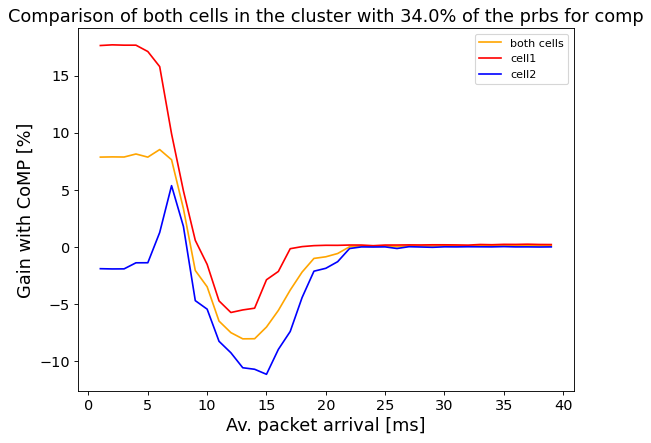

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(ran,(l+l2)/2,label='both cells',color='orange')
plt.plot(ran,l,label='cell1',color='red')
plt.plot(ran,l2,label='cell2',color='blue')
plt.xlabel('Av. packet arrival [ms]')
plt.title('Comparison of both cells in the cluster with '+ str(prb_number_comp*100/max_prb)+'% of the prbs for comp')
plt.ylabel('Gain with CoMP [%]')
plt.legend(loc='upper right')


In [28]:
BS_pos

array([51.33943333, 12.38343333, 51.34256111, 12.37955278])

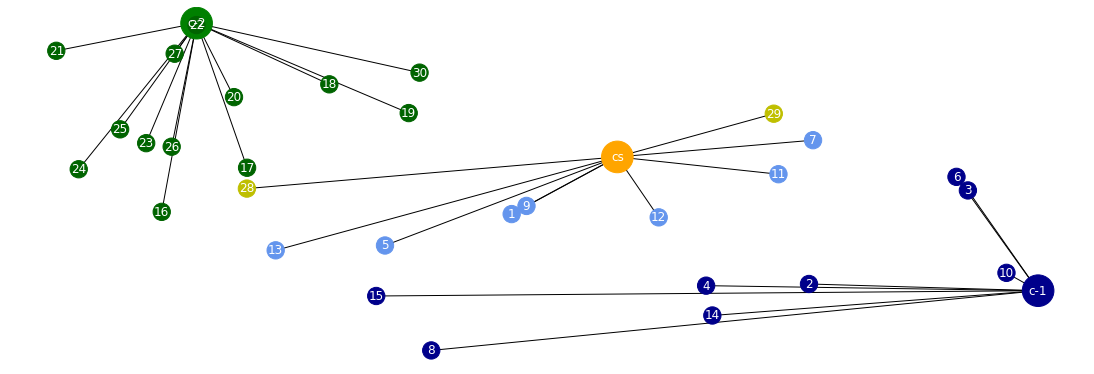

In [60]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
d={}
for i in df_cell.index:
    d.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lat'],df_cell.loc[i]['lon']]})
    
BS_pos=np.array([])
for i in cluster:
    BS_pos=np.append(BS_pos,d[i])

G=nx.Graph()

x=np.arange(1,ue_nr*2)
G.add_node('cs')
G.add_node('c-1')
G.add_node('c-2')

loc_dic={}
loc_dic.update({'cs':[(BS_pos[1]+BS_pos[3])/2,(BS_pos[0]+BS_pos[2])/2]})
loc_dic.update({'c-1':[BS_pos[1],BS_pos[0]]}) 
loc_dic.update({'c-2':[BS_pos[3],BS_pos[2]]})     
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    counter+=1

G.add_nodes_from(x)

n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    #loc_dic.update({counter:[i.x,i.y]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        if(i.cell1==cluster[0]):
            n_c=np.append(n_c,'cornflowerblue')
        elif(i.cell1==cluster[1]):
            n_c=np.append(n_c,'y')
    else:
        if(i.cell1==cluster[0]):
            G.add_edge(counter,'c-1')
            n_c=np.append(n_c,'darkblue')
        elif(i.cell1==cluster[1]):
            G.add_edge(counter,'c-2')
            n_c=np.append(n_c,'darkgreen')
    counter+=1
            
n_s=np.ones(ue_nr*2+3)*300
n_s[0:3]=1000

m=np.array([])
m=np.append(m,[1,1,1])
t=np.array([])
t=np.append(t,[1,1,1])
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs2)
    else:
        t=np.append(t,i.tbs)
vmin = np.min(m)
vmax = np.max(m)
m=10*np.log10(m)

plt.figure(3,figsize=(15,5)) 
#cmap='RdBu'
cmap='RdYlGn'
if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)
plt.draw()
plt.show()